# Difference between ML and DL on image classification




# 1. Import Packages

In [31]:
import numpy as np
import cv2
from scipy.io import loadmat
from sklearn.model_selection import KFold, train_test_split
import keras
from keras import optimizers
from keras.layers import *
from keras.models import Sequential
from skimage.util import montage
import matplotlib.pylab as plt
from pathlib import Path
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report



# 2. Read Data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("alessiocorrado99/animals10")

print("Path to dataset files:", path)

100%|██████████| 586M/586M [00:08<00:00, 75.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/alessiocorrado99/animals10/versions/2


In [3]:
# Load the data
def convert_path_to_df(dataset):
    image_dir = Path(dataset)

    # Get filepaths and labels
    filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.PNG'))

    labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

    filepaths = pd.Series(filepaths, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    image_df = pd.concat([filepaths, labels], axis=1)
    return image_df

# When using Google Colab
dataset = path
# dataset = "./AnimalRecognition_Data"

image_df_italian = convert_path_to_df(dataset)
translate = {"cane": "dog", "cavallo": "horse", "elefante": "elephant", "farfalla": "butterfly", "gallina": "chicken", "gatto": "cat", "mucca": "cow", "pecora": "sheep", "scoiattolo": "squirrel", "ragno":"spider"}

# Plot the first image of each animal (with english names)
# Translate the labels in the dataframe
image_df = convert_path_to_df(dataset)
image_df['Label'] = image_df['Label'].map(translate)


## Selecting a certain amount of images from each class

In [4]:
# prompt: create a dataframe in which only 100 rows from each label are present

# Assuming image_df is already defined as in your provided code
def create_balanced_dataframe_samp(df, n_samples_per_class):
    balanced_df = pd.DataFrame(columns=['Filepath', 'Label'])
    for label in df['Label'].unique():
        label_df = df[df['Label'] == label].sample(n=n_samples_per_class, random_state=42) # Random state for reproducibility
        balanced_df = pd.concat([balanced_df, label_df])
    return balanced_df



# prompt: create a new df where from each label as many rows are present as the minimum amount of labels

import pandas as pd

def balance_dataframe_min(df):
    # Count occurrences of each label
    label_counts = df['Label'].value_counts()

    # Find the minimum count among all labels
    min_count = label_counts.min()

    # Create a new balanced DataFrame
    balanced_df = pd.DataFrame(columns=df.columns)

    for label in label_counts.index:
        # Sample 'min_count' rows for the current label
        label_df = df[df['Label'] == label].sample(n=min_count, random_state=42) # Use random_state for reproducibility
        balanced_df = pd.concat([balanced_df, label_df])

    return balanced_df

# balanced_image_df = create_balanced_dataframe_samp(image_df, 100)

balanced_image_df = balance_dataframe_min(image_df)

balanced_image_df

,Filepath,Label
22007,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
23173,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
22472,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
21925,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
22879,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
...,...,...
16389,/root/.cache/kagglehub/datasets/alessiocorrado...,elephant
16424,/root/.cache/kagglehub/datasets/alessiocorrado...,elephant
16588,/root/.cache/kagglehub/datasets/alessiocorrado...,elephant
16154,/root/.cache/kagglehub/datasets/alessiocorrado...,elephant


## The resulting class distributions

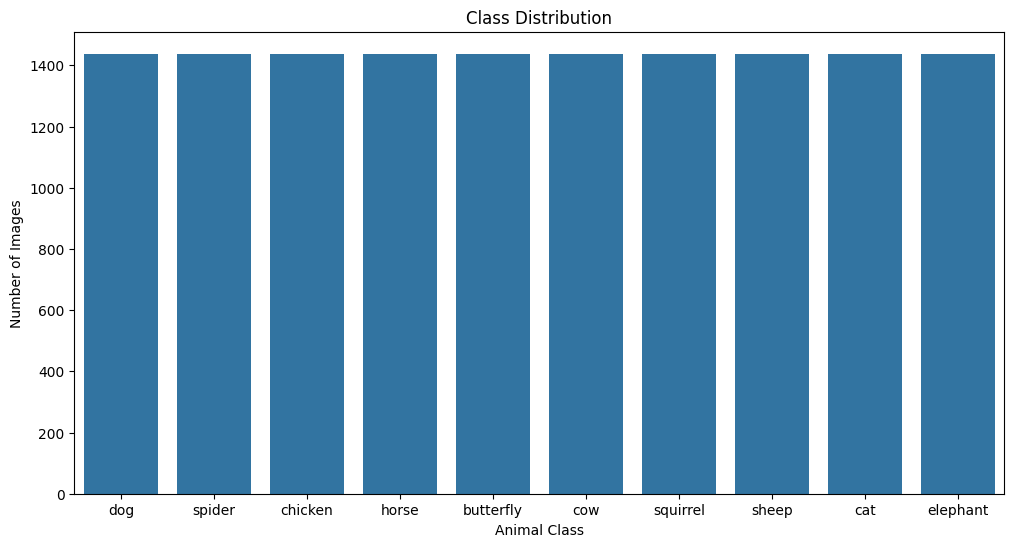

In [5]:
# prompt: plot the class distribution

plt.figure(figsize=(12, 6))
sns.countplot(x='Label', data=balanced_image_df)
plt.title('Class Distribution')
plt.xlabel('Animal Class')
plt.ylabel('Number of Images')
plt.show()

In [6]:
balanced_image_df.head()

# prompt: restart the numbering of the balanced image df of the index

# Reset the index of the balanced_image_df DataFrame
balanced_image_df = balanced_image_df.reset_index(drop=True)

# Display the updated DataFrame with the new index
balanced_image_df.head()

,Filepath,Label
0,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
1,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
2,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
3,/root/.cache/kagglehub/datasets/alessiocorrado...,dog
4,/root/.cache/kagglehub/datasets/alessiocorrado...,dog


## Load jpeg data as numpy arrays

In [7]:
# Function to get image sizes
def get_image_sizes(image_df):
    sizes = []
    for filepath in image_df['Filepath']:
        img = cv2.imread(filepath)
        if img is not None:
            sizes.append(img.shape[:2])  # Get height and width
        else:
            sizes.append((None, None))  # Handle case where image is not read properly
    return sizes

# # Get image sizes
# image_sizes = get_image_sizes(image_df)

# # Add image sizes to the dataframe
# image_df['ImageSize'] = image_sizes

# # Display the dataframe with image sizes
# print(image_df[['Filepath', 'ImageSize']])

# unique_image_sizes = image_df['ImageSize'].value_counts()
# print(unique_image_sizes)

In [8]:
im_size = 64
# Load the data
def load_images(image_dataframe):
    images = []
    for i in range(len(image_dataframe)):
        img = cv2.imread(image_dataframe['Filepath'][i])
        img = cv2.resize(img, (im_size, im_size))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return np.array(images)

images = load_images(balanced_image_df)

# Create a variable labels with shape (28098,) that stores the labels of each image
labels = balanced_image_df['Label'].values

In [9]:
im_size = 64
print(images.shape)
print(labels.shape)

(14380, 64, 64, 3)
(14380,)


## Plot the data

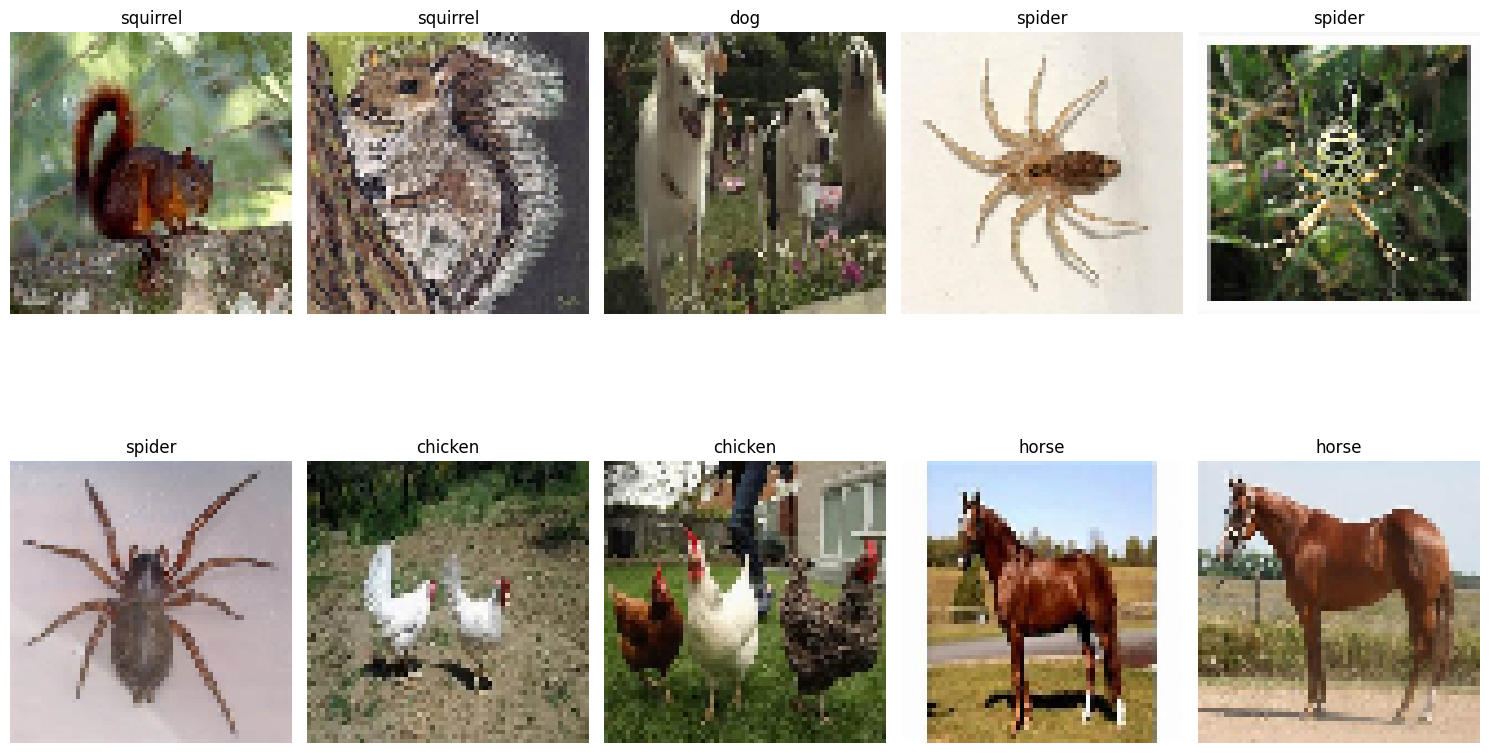

In [10]:
import random

import matplotlib.pyplot as plt

# Select 10 random indices
random_indices = random.sample(range(len(images)), 10)

# Plot the images with their corresponding labels
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(labels[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

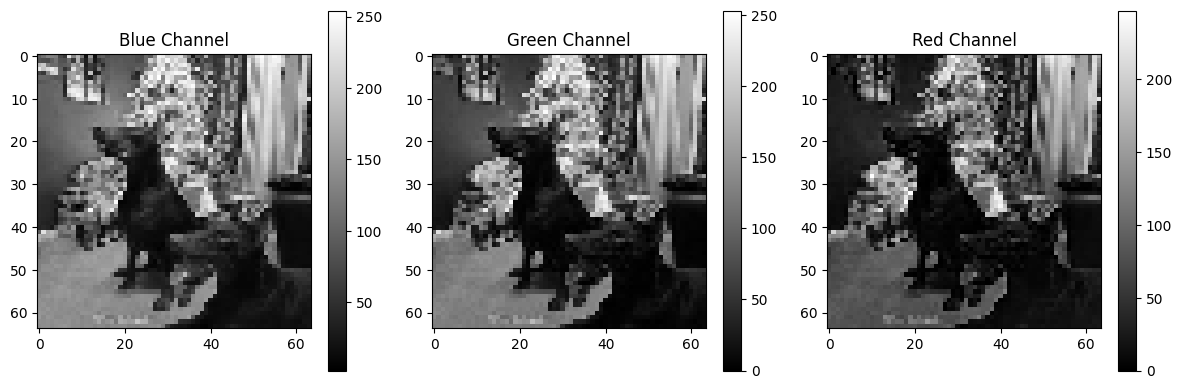

In [11]:
# prompt: take one image and plot the three color channels with colorbar

import matplotlib.pyplot as plt

# Assuming 'images' is your NumPy array of images and you've already selected an index
image_index = 0  # Replace with the index of the image you want to plot

# Split the image into its color channels
b, g, r = cv2.split(images[image_index])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each color channel with a colorbar
axes[0].imshow(b, cmap='gray')
axes[0].set_title('Blue Channel')
plt.colorbar(axes[0].imshow(b, cmap='gray'), ax=axes[0])  # Add colorbar to the first subplot

axes[1].imshow(g, cmap='gray')
axes[1].set_title('Green Channel')
plt.colorbar(axes[1].imshow(g, cmap='gray'), ax=axes[1]) # Add colorbar to the second subplot

axes[2].imshow(r, cmap='gray')
axes[2].set_title('Red Channel')
plt.colorbar(axes[2].imshow(r, cmap='gray'), ax=axes[2]) # Add colorbar to the third subplot


plt.tight_layout()
plt.show()

In [12]:
# prompt: normalize each of the three color channels to have values between 0 and 1

# Normalize each color channel to the range [0, 1]
images_normalized = []
for img in images:
    b, g, r = cv2.split(img)
    b_norm = b / 255.0
    g_norm = g / 255.0
    r_norm = r / 255.0
    normalized_img = cv2.merge((b_norm, g_norm, r_norm))
    images_normalized.append(normalized_img)

images_norm = np.array(images_normalized)


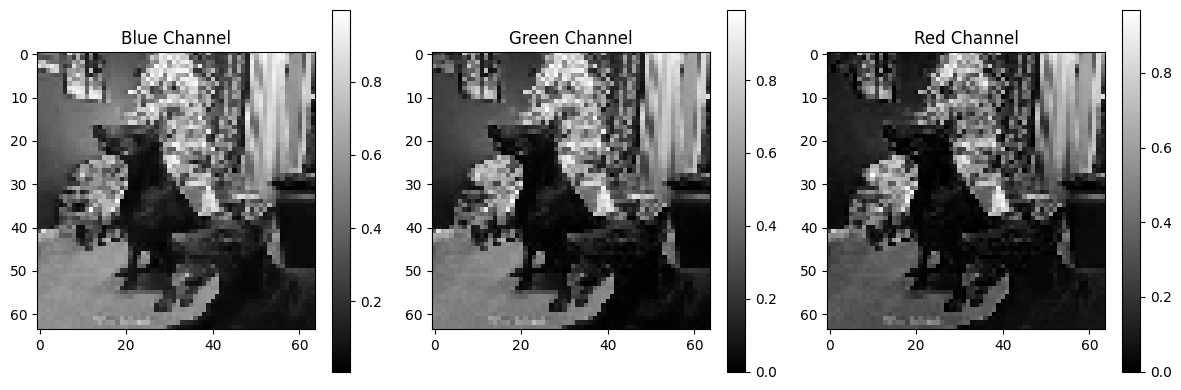

In [13]:
# prompt: take one image and plot the three color channels with colorbar

import matplotlib.pyplot as plt

# Assuming 'images' is your NumPy array of images and you've already selected an index
image_index = 0  # Replace with the index of the image you want to plot

# Split the image into its color channels
b, g, r = cv2.split(images_norm[image_index])

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot each color channel with a colorbar
axes[0].imshow(b, cmap='gray')
axes[0].set_title('Blue Channel')
plt.colorbar(axes[0].imshow(b, cmap='gray'), ax=axes[0])  # Add colorbar to the first subplot

axes[1].imshow(g, cmap='gray')
axes[1].set_title('Green Channel')
plt.colorbar(axes[1].imshow(g, cmap='gray'), ax=axes[1]) # Add colorbar to the second subplot

axes[2].imshow(r, cmap='gray')
axes[2].set_title('Red Channel')
plt.colorbar(axes[2].imshow(r, cmap='gray'), ax=axes[2]) # Add colorbar to the third subplot


plt.tight_layout()
plt.show()

# 3. Dataset splitting

## Split dataset into training and testing sets


In [14]:
X_train_val = train_test_split(images_norm, labels, test_size = 0.20, random_state = 42, shuffle = True)[0]
y_train_val = train_test_split(images_norm, labels, test_size = 0.20, random_state = 42, shuffle = True)[2]
X_test = train_test_split(images_norm, labels, test_size = 0.20, random_state = 42, shuffle = True)[1]
y_test = train_test_split(images_norm, labels, test_size = 0.20, random_state = 42, shuffle = True)[3]

In [15]:
print("X_train_val shape:", X_train_val.shape, "Data type:", X_train_val.dtype)
print("y_train_val shape:", y_train_val.shape, "Data type:", y_train_val.dtype)
print("x_test shape:", X_test.shape, "Data type:", X_test.dtype)
print("y_test shape:", y_test.shape, "Data type:", y_test.dtype)

X_train_val shape: (11504, 64, 64, 3) Data type: float64
y_train_val shape: (11504,) Data type: object
x_test shape: (2876, 64, 64, 3) Data type: float64
y_test shape: (2876,) Data type: object


## Check class distributions

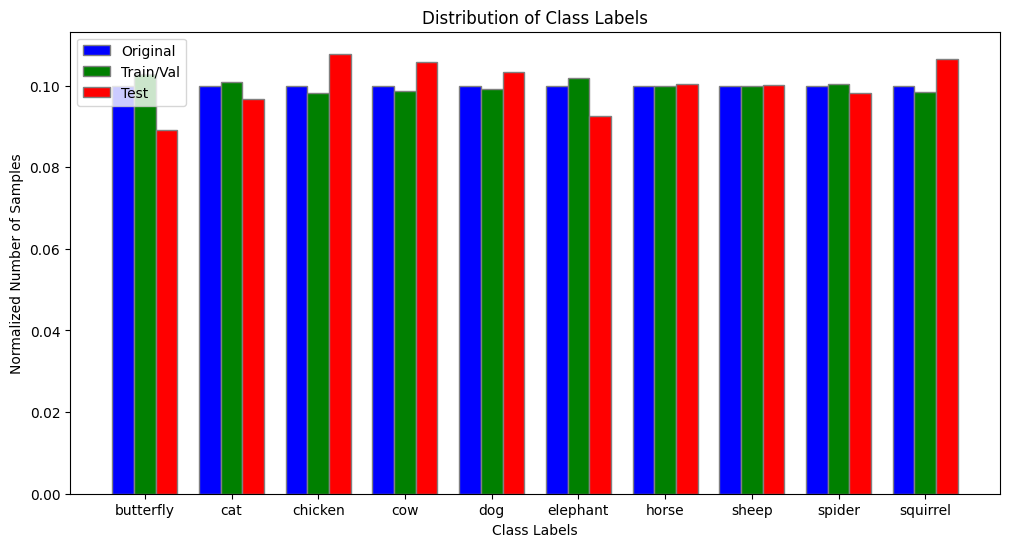

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Original labels distribution
original_labels, original_counts = np.unique(labels, return_counts=True)
# y_train_val distribution
train_val_labels, train_val_counts = np.unique(y_train_val, return_counts=True)
# y_test distribution
test_labels, test_counts = np.unique(y_test, return_counts=True)

# Normalize the counts
original_counts_normalized = original_counts / original_counts.sum()
train_val_counts_normalized = train_val_counts / train_val_counts.sum()
test_counts_normalized = test_counts / test_counts.sum()

# Define the width of the bars
bar_width = 0.25

# Define the positions of the bars
r1 = np.arange(len(original_labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot the distributions
plt.figure(figsize=(12, 6))
plt.bar(r1, original_counts_normalized, color='b', width=bar_width, edgecolor='grey', label='Original')
plt.bar(r2, train_val_counts_normalized, color='g', width=bar_width, edgecolor='grey', label='Train/Val')
plt.bar(r3, test_counts_normalized, color='r', width=bar_width, edgecolor='grey', label='Test')

# Add labels
plt.xlabel("Class Labels")
plt.ylabel("Normalized Number of Samples")
plt.title("Distribution of Class Labels")
plt.xticks([r + bar_width for r in range(len(original_labels))], original_labels)
plt.legend()
plt.show()


## Plot some images from the training and testing set

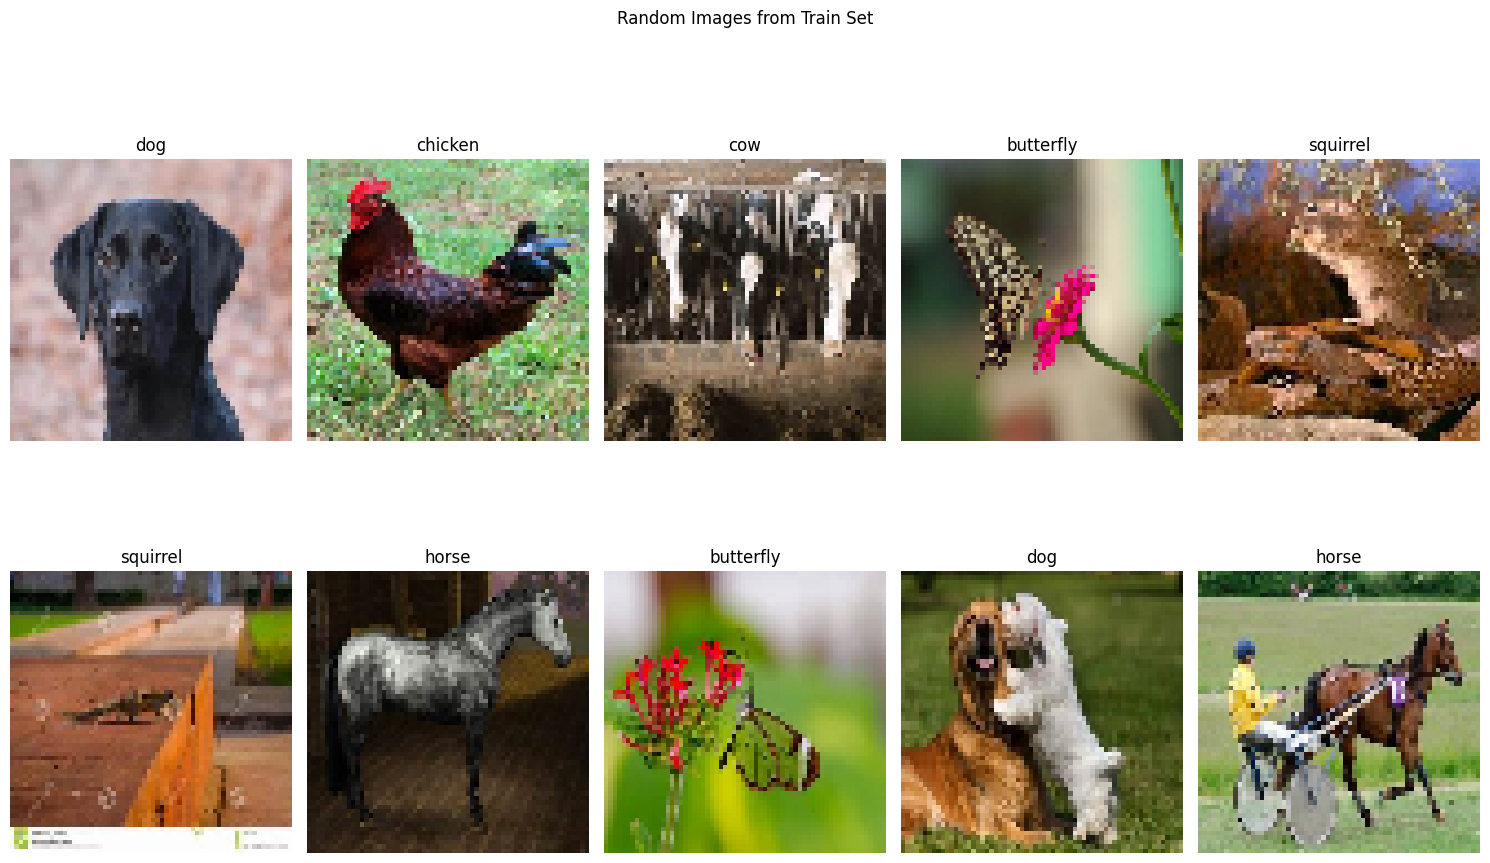

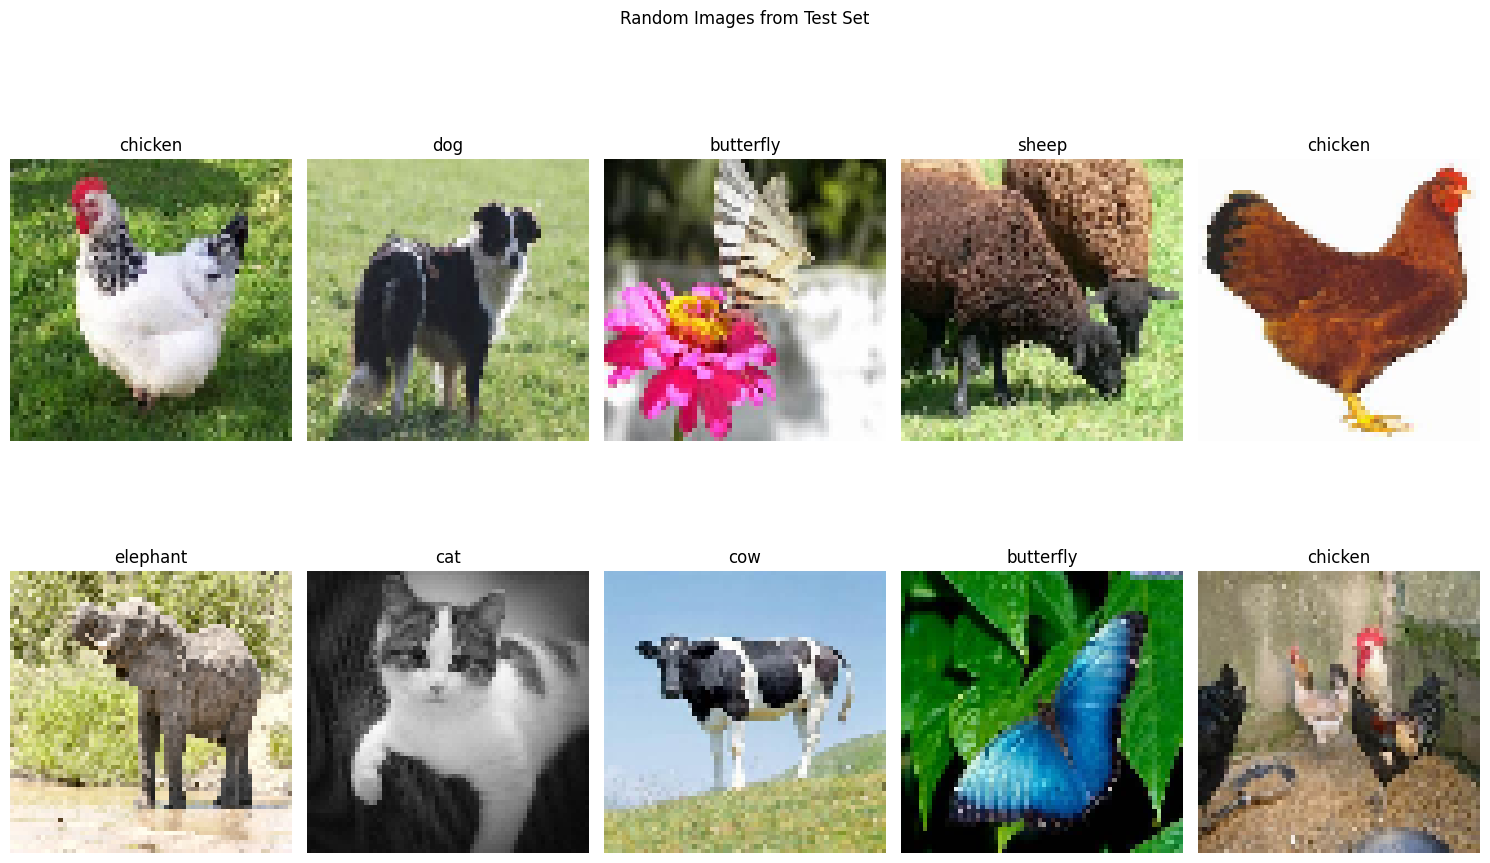

In [17]:
import random

import matplotlib.pyplot as plt

# Select 10 random indices from the train set
random_indices_train = random.sample(range(len(X_train_val)), 10)

# Plot the images with their corresponding labels from the train set
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices_train):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_train_val[idx])
    plt.title(y_train_val[idx])
    plt.axis('off')
plt.suptitle('Random Images from Train Set')
plt.tight_layout()
plt.show()

# Select 10 random indices from the test set
random_indices_test = random.sample(range(len(X_test)), 10)

# Plot the images with their corresponding labels from the test set
plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices_test):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[idx])
    plt.title(y_test[idx])
    plt.axis('off')
plt.suptitle('Random Images from Test Set')
plt.tight_layout()
plt.show()

## One-Hot Encoding of labels

Convert the ground truth (labels) to categorical.
For example, if there are 4 classes:
* y = 0 --> 0000
* y = 1 --> 0010
* y = 2 --> 0100
* y = 3 --> 1000

In [18]:
# prompt: hot-encode the y_train and y_test

from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the training labels
y_train_val_int = label_encoder.fit_transform(y_train_val)

y_test_int = label_encoder.transform(y_test)

print(y_train_val_int.shape)
print(y_test_int)

# One hot encoding

import tensorflow as tf
num_classes = 10
y_train_val_enc = keras.utils.to_categorical(y_train_val_int, num_classes=num_classes)
y_train_val_enc = y_train_val_enc.astype('float32')

y_test_enc = keras.utils.to_categorical(y_test_int, num_classes=num_classes)
y_test_enc = y_test_enc.astype('float32')


num = 0
print(y_train_val[num],'-->',y_train_val_enc[num], y_train_val_int[num])
num = 400
print(y_train_val[num],'-->',y_train_val_enc[num], y_train_val_int[num])

(11504,)
[2 1 2 ... 1 6 1]
cat --> [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
sheep --> [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.] 7


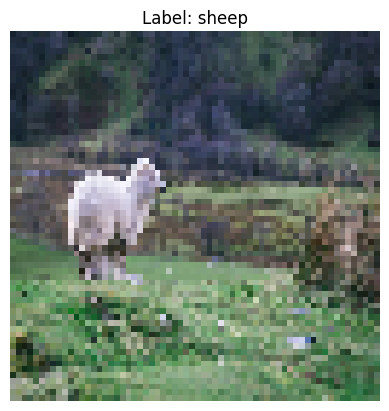

In [20]:
# prompt: plot X_train_val[400] together with its label

import matplotlib.pyplot as plt

# Assuming X_train_val and y_train_val are defined as in your provided code

# Select the image at index 400
image_index = 400
image = X_train_val[image_index]
label = y_train_val[image_index]

# Plot the image and display its label
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

# 4. Feature Extraction

## Extract the hand-crafted features

In [21]:
from skimage.feature import local_binary_pattern, hog, graycomatrix, graycoprops
from skimage.color import rgb2gray
import numpy as np
def extract_features(images):
    features = []
    for image in images:
        # Convert image to grayscale
        gray_image = rgb2gray(image)

        # Color histogram (RGB)
        hist_r = np.histogram(image[:, :, 0], bins=256, range=(0, 256))[0]
        hist_g = np.histogram(image[:, :, 1], bins=256, range=(0, 256))[0]
        hist_b = np.histogram(image[:, :, 2], bins=256, range=(0, 256))[0]
        color_hist = np.concatenate((hist_r, hist_g, hist_b))

        # Histogram of Oriented Gradients (HOG)
        hog_features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), feature_vector=True)

        # Gray Level Co-occurrence Matrix (GLCM)
        glcm = graycomatrix((gray_image * 255).astype(np.uint8), distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
        homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
        energy = graycoprops(glcm, 'energy')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]
        glcm_features = [contrast, dissimilarity, homogeneity, energy, correlation]

        # Mean and Standard Deviation
        mean = np.mean(image)
        std = np.std(image)

        # Combine all features
        combined_features = np.concatenate((color_hist, hog_features, glcm_features,[mean, std]))
        features.append(combined_features)

    return np.array(features)

In [22]:
# Extract features for training and validation set
X_train_val_features = extract_features(X_train_val)

# Extract features for test set
X_test_features = extract_features(X_test)

print("X_train_val_features shape:", X_train_val_features.shape)
print("X_test_features shape:", X_test_features.shape)

X_train_val_features shape: (11504, 2539)
X_test_features shape: (2876, 2539)


In [23]:
print(X_train_val_features)
feat_train_val = X_train_val_features
feat_test = X_test_features

[[4.09600000e+03 0.00000000e+00 0.00000000e+00 ... 9.15819163e-01
  8.68262995e-02 1.66686316e-01]
 [4.09200000e+03 4.00000000e+00 0.00000000e+00 ... 8.36676947e-01
  5.66610179e-01 2.39927570e-01]
 [4.09600000e+03 0.00000000e+00 0.00000000e+00 ... 4.75622108e-01
  4.71455653e-01 1.72021886e-01]
 ...
 [4.09500000e+03 1.00000000e+00 0.00000000e+00 ... 6.89471928e-01
  3.32038909e-01 1.57544678e-01]
 [4.09300000e+03 3.00000000e+00 0.00000000e+00 ... 9.53942992e-01
  3.95331010e-01 3.64263597e-01]
 [4.09600000e+03 0.00000000e+00 0.00000000e+00 ... 8.77461122e-01
  3.46488843e-01 2.38951421e-01]]


In [24]:
# Check if the values of the feature vectors are normalized
print("Min value in feat_train_val:", np.min(feat_train_val))
print("Max value in feat_train_val:", np.max(feat_train_val))
print("Min value in feat_test:", np.min(feat_test))
print("Max value in feat_test:", np.max(feat_test))

Min value in feat_train_val: 0.0
Max value in feat_train_val: 7744.505456349207
Min value in feat_test: 0.0
Max value in feat_test: 6170.322172619049


## Normalize the feature vectors

In [25]:
from sklearn.preprocessing import RobustScaler

# Initialize the scaler
scaler = RobustScaler()

# Fit the scaler on the training features and transform them
feat_train_val = scaler.fit_transform(feat_train_val)

# Transform the test features using the same scaler
feat_test = scaler.transform(feat_test)

# Verify the normalization
print("Min value in feat_train_val_normalized:", np.min(feat_train_val))
print("Max value in feat_train_val_normalized:", np.max(feat_train_val))
print("Min value in feat_test_normalized:", np.min(feat_test))
print("Max value in feat_test_normalized:", np.max(feat_test))

Min value in feat_train_val_normalized: -1580.0
Max value in feat_train_val_normalized: 1580.0
Min value in feat_test_normalized: -1486.0
Max value in feat_test_normalized: 1486.0


# 5. Training of the ML classifiers

In [27]:
cl1 = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
cl2 = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state=42)
cl3 = DecisionTreeClassifier(random_state=42)
cl4 = RandomForestClassifier(random_state=42)
cl5 = xgb.XGBClassifier(objective="multi:softprob", random_state=42, reg_alpha = 0.1, reg_lambda = 1)
cl6 = MLPClassifier(solver='adam', activation = 'relu', alpha=1e-5, hidden_layer_sizes=(100,), random_state=42, max_iter = 500, early_stopping = False)
cl7 = SVC(kernel='linear', C=1, probability=True)
cl8 = SVC(kernel='poly', degree = 3, probability=True)

classifiers = [cl1, cl2, cl3, cl4, cl5, cl6]
classifier_names = ['KNN', 'Logistic Regression','Decision Tree', 'Random Forest', 'XGBoost', 'Multi-Layer Perceptron']

## Overview of ML models with evaluation metric (accuracy) on train and validation set

In [28]:
def model_evaluation(cl, model_name, feat_train_val, y_train_val):
  ACC_train = []
  ACC_val = []
  kf = KFold(n_splits=5, shuffle=True, random_state=None)
  for cv_train_index, cv_val_index in kf.split(feat_train_val):
      feat_cv_train, feat_cv_val = feat_train_val[cv_train_index], feat_train_val[cv_val_index]
      y_cv_train, y_cv_val = y_train_val[cv_train_index], y_train_val[cv_val_index]
      #Train
      cl.fit(feat_cv_train, y_cv_train)
      #Predict
      yhat_val = cl.predict(feat_cv_val)
      yhat_train = cl.predict(feat_cv_train)
      #Compute CV metrics
      acc_val = accuracy_score(y_cv_val, yhat_val, normalize=True, sample_weight=None)
      ACC_val.append(acc_val)
      acc_train = accuracy_score(y_cv_train, yhat_train, normalize=True, sample_weight=None)
      ACC_train.append(acc_train)

  # yhat_test_ML = cl.predict(feat_test)
  # test_acc_ML = accuracy_score(y_test, yhat_test_ML, normalize=True, sample_weight=None)

  print(f'--------Evaluation metric for {model_name}------------')
  print('Accuracy for training set: ', np.mean(ACC_train))
  print('Accuracy for validation set: ', np.mean(ACC_val))
  print(' ')
  # print('Accuracy for test set: ', test_acc_ML)

  return None

In [ ]:
model_evaluation(cl1, 'K-Nearest Neighbors',  feat_train_val, y_train_val_int)

--------Evaluation metric for K-Nearest Neighbors------------
Accuracy for training set:  0.47679078865455093
Accuracy for validation set:  0.2601705496664966
 


In [ ]:
model_evaluation(cl2, 'Logistic Regression',  feat_train_val, y_train_val_int)

--------Evaluation metric for Logistic Regression------------
Accuracy for training set:  0.8307980061298341
Accuracy for validation set:  0.35370353154583073
 


In [ ]:
model_evaluation(cl3, 'Decision Tree',  feat_train_val, y_train_val_int)

--------Evaluation metric for Decision Tree------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.19801813956124936
 


In [ ]:
model_evaluation(cl4, 'Random Forest',  feat_train_val, y_train_val_int)

--------Evaluation metric for Random Forest------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.35778912760047615
 


In [29]:
model_evaluation(cl5, 'XGBoost',  feat_train_val, y_train_val_int)

--------Evaluation metric for XGBoost------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.44984177011885196
 


In [ ]:
model_evaluation(cl6, 'Multi-Layer Perceptron',  feat_train_val, y_train_val_int)

--------Evaluation metric for Multi-Layer Perceptron------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.4175075487028324
 


In [ ]:
model_evaluation(cl7, 'SVM (Linear Kernel)',  feat_train_val, y_train_val_int)

--------Evaluation metric for SVM (Linear Kernel)------------
Accuracy for training set:  1.0
Accuracy for validation set:  0.3508337395839238
 


## Evaluation of best ML classifier on hold-out test set

In [32]:
yhat_test_ML = cl5.predict(feat_test)
test_acc_ML = accuracy_score(y_test_int, yhat_test_ML, normalize=True, sample_weight=None)
test_confusion_matrix_ML = confusion_matrix(y_test_int, yhat_test_ML, labels=None, sample_weight=None, normalize=None)

In [33]:
print('Test ACC of the best ML model:', test_acc_ML)

Test ACC of the best ML model: 0.44993045897079276


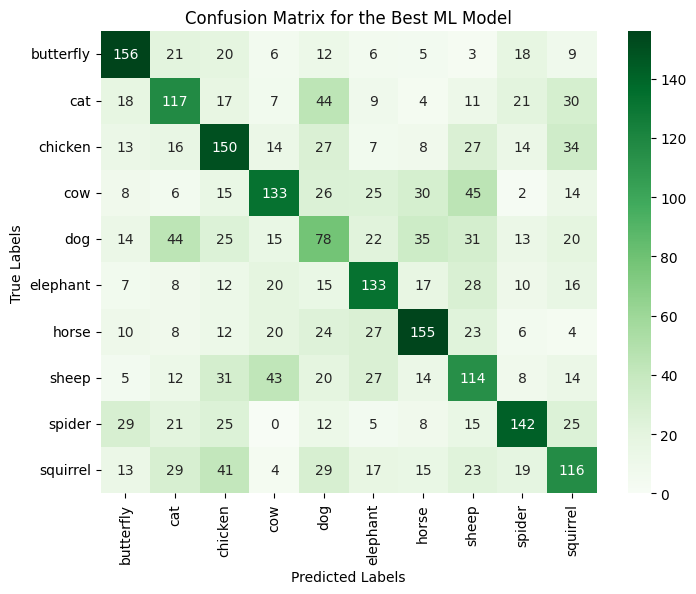

In [50]:
# Confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion_matrix_ML, annot=True, fmt="d", cmap=plt.cm.Greens, xticklabels=test_labels, yticklabels=test_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for the Best ML Model")
plt.show()


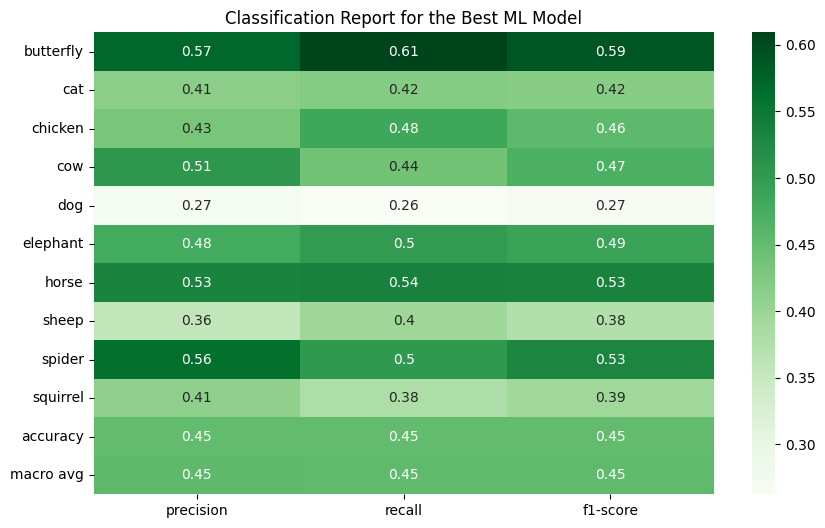

In [53]:
# Classification report

# Generate the classification report
report = classification_report(y_test_int, yhat_test_ML, target_names=list(test_labels), output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Greens')
plt.title('Classification Report for the Best ML Model')
plt.show()